In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random

In [3]:
train_data = np.loadtxt("mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt("mnist_test.csv", 
                       delimiter=",")

In [4]:
def to_one_hot(n):
    one_hot = [0]*10
    one_hot[n] = 1
    return one_hot

In [5]:
def get_random_patch(x, y, n):
    idx = np.asarray(random.sample(range(x.shape[0]), n))
    return x[idx], y[idx]

In [6]:
test_labels = test_data[:, 0].astype(int)
# test_labels_one_hot = np.asarray([to_one_hot(int(x.tolist())) for x in test_labels])
test_images = test_data[:, 1:].reshape(-1, 28*28) / 255.
train_labels = train_data[:, 0].astype(int)
# train_labels_one_hot = np.asarray([to_one_hot(int(x.tolist())) for x in train_labels])
train_images = train_data[:, 1:].reshape(-1, 28*28) / 255.

In [7]:
def get_accuracy(y, y_):
    y__ = np.zeros_like(y_)
    y__[np.arange(y_.shape[0]), np.argmax(y_, axis=1)] = 1
    ret = np.all(y == y__, axis=1)
    return ret.sum()/ret.shape[0]

In [8]:
ALPHA = 0.001
NUM_EPOCHS = 1

Dataset

In [9]:
class MNIST_Trainset(Dataset):
    def __len__(self):
        return train_images.shape[0]
    
    def __getitem__(self, idx):
        return {"images" : train_images[idx], "labels" : train_labels[idx]}

In [10]:
MNIST_loader = DataLoader(MNIST_Trainset(), batch_size=40, shuffle=True)

In [21]:
dataset = MNIST_Trainset()

Model

In [10]:
IN = 28*28
HID_1 = 100
HID_2 = 100
HID_3 = 100
OUT = 10

Sequenziale

In [11]:
model = nn.Sequential(
    torch.nn.Linear(IN, HID_1),
    nn.ReLU(),
    torch.nn.Linear(HID_1, HID_2),
    nn.ReLU(),
    torch.nn.Linear(HID_2, HID_3),
    nn.ReLU(),
    torch.nn.Linear(HID_3, OUT),
#    nn.Softmax(dim=1)
)

Generico

In [ ]:
model = FullYConnected()

In [ ]:
class FullYConnected(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(IN, HID_1)
        self.linear2 = torch.nn.Linear(HID_1, HID_2)
        self.linear3 = torch.nn.Linear(HID_2, HID_3)
        self.linear4 = torch.nn.Linear(HID_3, OUT)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return F.softmax(self.linear4(x), dim=1)

In [ ]:
model.cuda()

Addestramento

In [19]:
START_EPOCH = 0
N_EPOCHS = 1

Training from scratch

In [180]:
l_idxs=random.sample(range(784), int(784/2))
r_idxs=list(set(range(28*28)).difference(l_idxs))
model = MyNet(n_in=28*28, n_out=10, l_layers_n=[int(784/2), 34, 67, 2], r_layers_n=[int(784/2), 34, 67, 8], 
      lf=F.relu, rf=F.tanh, l_idxs=l_idxs, r_idxs=r_idxs)

In [182]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [183]:
train_losses = []
test_losses = []
accuracies = []

<IPython.core.display.Javascript object>


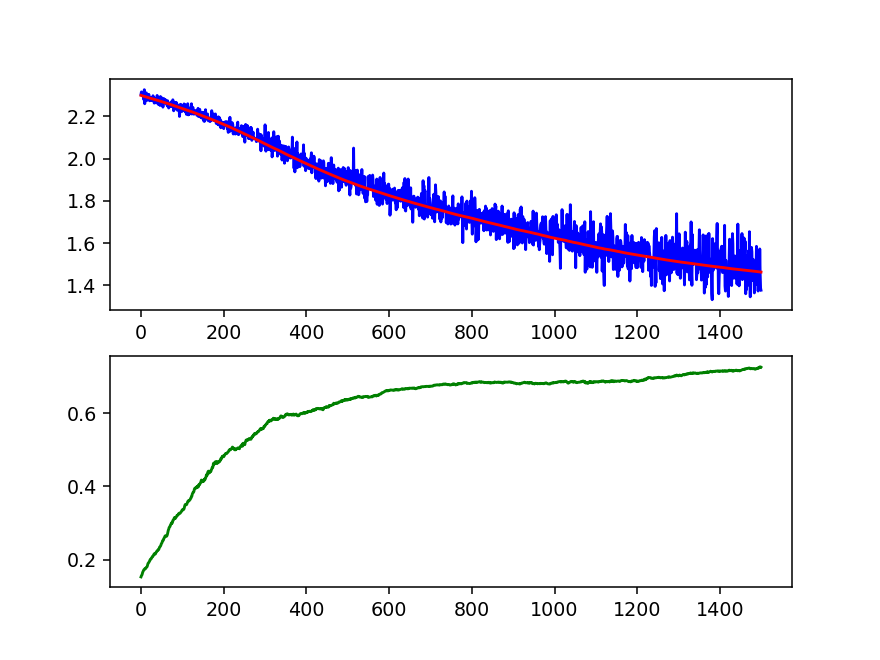

C:\Users\btlgs\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [184]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
for epoch in range(START_EPOCH, START_EPOCH + N_EPOCHS):
    for mb in MNIST_loader:
        optimizer.zero_grad()
        y = model(mb["images"].float())
        loss = F.cross_entropy(y, mb["labels"].long())
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        batch_images, batch_labels = get_random_patch(test_images, test_labels, 1000)
        with torch.no_grad():
            y = model(torch.from_numpy(test_images).float())
        loss = F.cross_entropy(y, torch.from_numpy(test_labels).long())
        test_losses.append(loss.item())
        acc = get_accuracy([to_one_hot(label) for label in test_labels], y.numpy())
        accuracies.append(acc)
        ax1.clear()
        ax2.clear()
        ax1.plot(train_losses, "b")
        ax1.plot(test_losses, "r")
        ax2.plot(accuracies, "g")
        fig.canvas.draw()

In [148]:
def lr_finder(model, exp_start, exp_end, n, xs, ys):
    losses = []
    lrs = np.logspace(exp_start, exp_end, num=100)
    for lr in lrs:
        x, y = random.choice(list(zip(xs, ys)))
        y_, loss = nn.forward(x.reshape(-1, 28*28), y)
        nn.backward(y, y_)
        nn.gradient_descent_step(lr)
        losses.append(loss)
    return lrs, losses